In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gp

In [2]:
SAMPLE_SIZE = 10e3

In [3]:
df = pd.read_csv("data/rows.csv", 
        nrows=SAMPLE_SIZE, 
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
        infer_datetime_format=True,
        dtype={"store_and_fwd_flag": "bool"},
        true_values=["Y"],
        false_values=["N"],
)
df = df.rename(
    columns = {
        "VendorID": "vendor_id", 
        "RatecodeID": "ratecode_id",
        "PULocationID": "pickup_loc_id",
        "DOLocationID": "dropoff_loc_id"
    }
)

In [4]:
G = nx.from_pandas_edgelist(
    df, 
    source="pickup_loc_id",
    target="dropoff_loc_id",
    edge_attr=True,
    create_using=nx.DiGraph
)

In [5]:
geo = gp.read_file("data/NYC Taxi Zones/geo_export_38097766-152c-469f-95c0-313056068b21.shp")

In [6]:
for node in G.nodes:
    try:
        G.nodes[node]['pos'] = list(geo[geo["objectid"] == node].centroid.iloc[0].coords)[0]
        G.nodes[node]['zone'] = geo[geo["objectid"] == node].zone.iloc[0]
    except:
        G.nodes[node]['pos'] = list(geo[geo["objectid"] == 1].centroid.iloc[0].coords)[0]
        G.nodes[node]['zone'] = geo[geo["objectid"] == 1].zone.iloc[0]

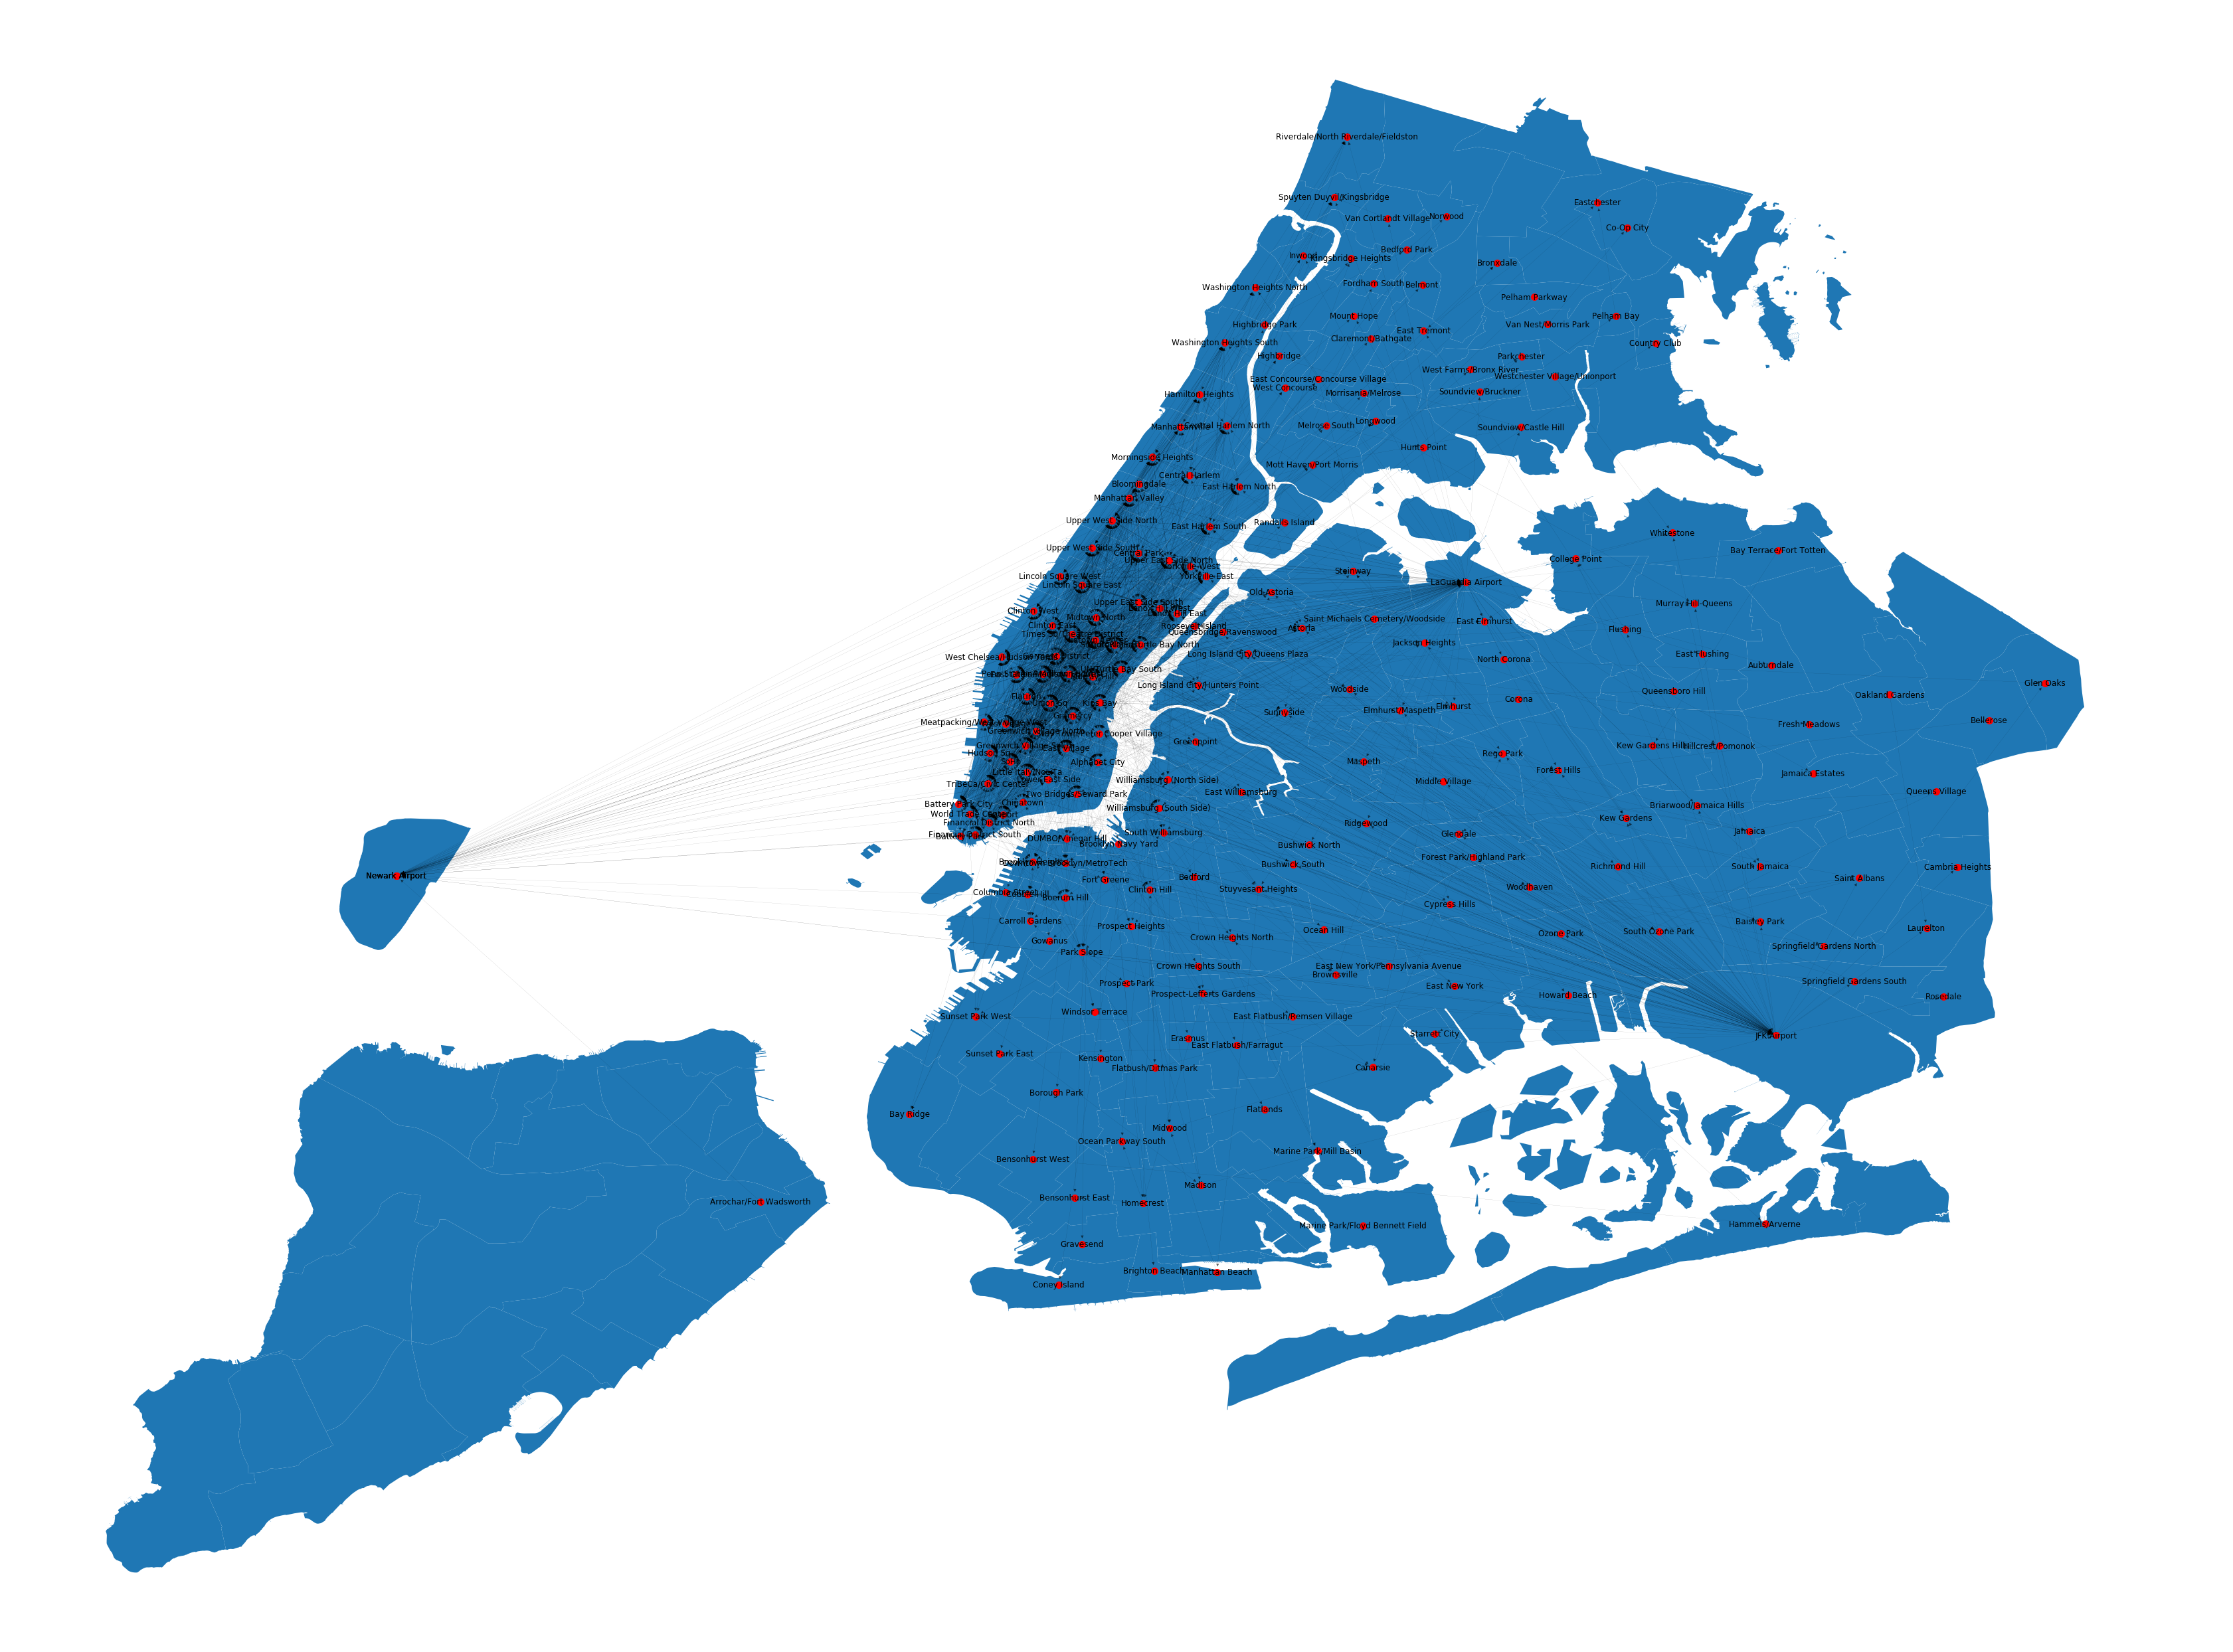

In [7]:
plt.figure(1,figsize=(60,60)) 
plt.axis('off')
nx.draw_networkx_nodes(G, nx.get_node_attributes(G, "pos"), node_size=100, node_color="red")
nx.draw_networkx_edges(G, nx.get_node_attributes(G, "pos"), alpha = 0.6, width=0.1)
nx.draw_networkx_labels(G, nx.get_node_attributes(G, "pos"), labels = nx.get_node_attributes(G, "zone"))

ax = plt.gca()
geo.plot(ax = ax)
plt.show()